<a href="https://colab.research.google.com/github/peter-hansson/msl-ws/blob/main/MachineLearning_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Workshop om maskininlärning

Välkomna till Machine Learning Housing Corporation!

Vår första uppgift är att använda data från folkräkningen i Kalifornien för att bygga en modell för bostadspriser i delstaten.

Denna data inkluderar mätvärden såsom

* befolkning
* medianinkomst
* medianbostadspris

för varje distrikt i Kalifornien.

Distrikt är den minsta geografiska enhet för vilken US Census Bureau publicerar data (ett distrikt har vanligtvis en befolkning på 600 till 3,000 personer).

Vår modell ska lära sig från denna data och kunna förutsäga medianbostadspriset i vilket distrikt som helst, givet alla andra mätvärden.

##Frågor till chefen

* **Vad är det egentligen affärsmålet med detta arbete?**

   Att känna till målet är viktigt eftersom det kommer att avgöra
   * Hur vi formulerar problemet
   * Vilka algoritmer vi väljer
   * Vilket prestandamått vi använder för att utvärdera vår modell

* **Hur förväntar sig företaget att använda och dra nytta av denna modell?**

  Utdatan från vår modell (en förutsägelse av medianhuspriset i ett distrikt)\
  kommer att matas in i ett annat maskininlärningssystem, tillsammans med\
  många andra signaler.
  Detta nedströms system kommer att avgöra om det är värt att investera\
  i ett visst område. Att få detta rätt är avgörande, eftersom det direkt påverkar intäkterna.
  
  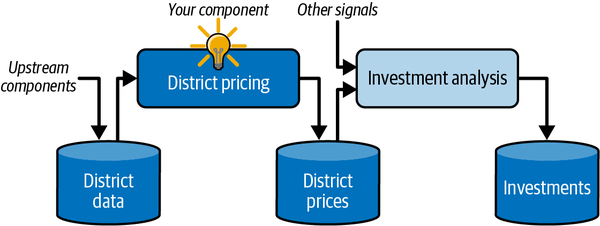

* **Hur ser den nuvarande lösningen ut?**

  För närvarande uppskattas distriktets bostadspriser manuellt av experter: ett team samlar\
  aktuell information om ett distrikt, och när de inte kan få fram medianhuspriset, uppskattar\
  de det med hjälp av komplexa regler.

Med all denna information är vi nu redo att börja designa vårt system.

Först måste vi bestämma vilken typ av träningstillsyn modellen kommer att behöva

* Övervakad(Supervised)
* Oövervakad(Unsupervised)
* Semi-övervakad(Semi-supervised)

Är det en

* Klassificeringsuppgift
* Regressionsuppgift
* Något annat

Bör vi använda

* Batchinlärning
* Onlineinlärning

Detta är tydligt en typisk övervakad inlärningsuppgift, eftersom modellen kan tränas med\
märkta(labeled) exempel (varje instans kommer med det förväntade resultatet, dvs. distriktets\
medianhuspris).

Det är en typisk regressionsuppgift, eftersom modellen kommer att ombeds att förutsäga\
ett värde. Mer specifikt är detta ett multipel regressionsproblem, eftersom systemet kommer\
att använda flera attribut för att göra en förutsägelse (distriktets befolkning, medianinkomsten, osv.).

Slutligen, eftersom det inte finns ett kontinuerligt flöde av data som kommer in i systemet,\
finns det inget särskilt behov av att snabbt anpassa sig till föränderliga data, och datan är tillräckligt liten\
för att rymmas i minnet, så vanlig batchinlärning bör fungera alldeles utmärkt.

##Välj ett prestandamått
Vårt nästa steg är att välja ett prestandamått.

Ett typiskt prestandamått för regressionsproblem är kvadratiskt medelrotsfel (RMSE). Det ger en uppfattning\
om hur mycket fel systemet typiskt gör i sina förutsägelser, med större vikt vid stora fel.


$$ \text{RMSE}(\mathbf{X}, h) = \sqrt{\frac{1}{m} \sum_{i=1}^m (h(\mathbf{x^{(i)}}) - y^{(i)})^2} $$

* *m* är antalet instanser i datamängden som vi mäter RMSE på.\
Till exempel, om vi utvärderar RMSE på ett valideringsset av 2 000 distrikt, då är m = 2 000.
<p>&nbsp</p>
* $x^{(i)}$ är en vektor av alla funktionsvärden (exklusive etiketten(label)) för den i:te instansen i datasetet\
och $y^{(i)}$ är dess etikett (det önskade utdatavärdet för den instansen).

  * Till exempel, om det första distriktet i datasetet ligger vid longitud –118,29°, latitud 33,91°,\
  och det har 1 416 invånare med en medianinkomst på \\$38 372, och medianhusvärdet\
  är $156 400 (ignorerar andra funktioner för tillfället), då är:

  $$ \mathbf{x^{(1)}} = \begin{bmatrix} -118.29 \\ 33.91 \\ 1,416 \\ 38,372 \end{bmatrix} $$
    och:
  $$y^{(1)} = 156,400 $$
<p>&nbsp</p>  
* X är en matris som innehåller alla funktionsvärden (exklusive etiketter) av alla instanser i datasetet.\
Det finns en rad per instans, och den i:te raden är lika med transponeringen av $x^{(i)}$, noterat $(x^{(i)})^\top$.
  * Till exempel, om det första distriktet är som just beskrivet, då ser matrisen X ut så här:

$$ \mathbf{X} = \begin{bmatrix} (\mathbf{x^{(1)}})^\top \\ (\mathbf{x^{(2)}})^\top \\ \vdots \\ (\mathbf{x^{(1999)}})^\top \\ (\mathbf{x^{(2000)}})^\top \end{bmatrix} = \begin{bmatrix} -118.29 \\ 33.91 \\ 1,416 \\ 38,372 \\ \vdots \end{bmatrix} $$
<p>&nbsp</p>

* h är din systems förutsägelsefunktion, även kallad en hypotes. När ditt system får en instans\
funktionsvektor x(i), ger det ett förutsagt värde $ \hat{y}^{(i)} = h(x^{(i)}) $ för den instansen $( \hat{y} $ uttalas "y-hatt").

  * Till exempel, om ditt system förutsäger att medianhuspriset i det första distriktet är \\$158 400,\
  då är $ \hat{y}^{(1)} = h(x^{(1)}$) = 158,400. Förutsägelsefelet för detta distrikt är $ \hat{y}^{(1)} - y^{(1)}$ = 2 000.
* RMSE(X, h) är kostnadsfunktionen mätt på exempelsamlingen med hjälp av din hypotes h.
<p>&nbsp</p>

Vi använder kursiv liten stil för skalära värden (som $m$ eller $y^{(i)}$) och funktionsnamn (som $h$),\
fetstil med små bokstäver för vektorer (som $\mathbf{x^{(i)}}$), och fetstil med stora bokstäver för matriser (som X).
<p>&nbsp</p>
<hr>
<p>&nbsp</p>

Även om RMSE generellt är det föredragna prestandamåttet för regressionsuppgifter, kan vi i vissa\
sammanhang föredra att använda en annan funktion. Till exempel, om det finns många avvikande distrikt.

I det fallet kan vi överväga att använda medelabsolutfelet (MAE, också kallat genomsnittligt absolut avvikelse),
<p>&nbsp</p>
$$ \text{MAE}(\mathbf{X}, h) = \frac{1}{m} \sum_{i=1}^m |h(\mathbf{x^{(i)}}) - y^{(i)}| $$
<p>&nbsp</p>

Både RMSE och MAE är sätt att mäta avståndet mellan två vektorer: vektorn av förutsägelser och målvektorn.\
Olika avståndsmått, eller normer, är möjliga:

* Beräkningen av roten ur en summa av kvadrater (RMSE) motsvarar Euklidisk norm: detta är avståndsbegreppet\
vi alla är bekanta med. Det kallas också ℓ2-normen, noterad $||$ · $||_2$ (eller bara $|| · ||$).

* Beräkningen av summan av absolutbelopp (MAE) motsvarar ℓ1-normen, noterad $|| · ||_1$. Detta kallas ibland\
"Manhattan-normen" eftersom den mäter avståndet mellan två punkter i en stad om du endast kan resa längs\
ortogonala stadskvarter.

* Mer generellt är $ℓ_\mathbf{k}$-normen för en vektor $\mathbf{v}$ som innehåller *n* element definierad som\
$||v||_k = (|v_1|^k + |v_2|^k + ... + |v_n|^k)^{1/k}$. ℓ0 ger antalet nollskilda element i vektorn, och ℓ∞ ger det maximala\
absoluta värdet i vektorn.

Ju högre normindex, desto mer fokuserar den på stora värden och försummar små sådana. Detta är anledningen till\
att RMSE är mer känslig för avvikelser än MAE. Men när avvikelser är exponentiellt sällsynta (som i en klockformad kurva),\
presterar RMSE mycket väl och är generellt föredragen.

#Förberedelse

Projektet kräver Python 3.7 eller senare:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

Det kräver även Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Ladda ner statistikdata

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Vad har vi för information?
Varje rad har information om ett distrikt.\
Det finns 10 attribut

In [ ]:
housing.head()

## Metadata

In [ ]:
housing.info()

Totalt finns det information om 20640 distrikt,\
notera att det saknas information om antal sovrum\
för 207 st distrikt

ocean_proximity är av datatypen objekt\
Vilka kategorier finns det?

In [ ]:
housing["ocean_proximity"].value_counts()

In [ ]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##Histogram
För att få en första överblick av informationen kan\
vi plotta ett histogram för varje attribut

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

##Skapa en testmängd
Att skapa en testmängd är i teorin enkelt. Välj ut 20% av informationen slumpmässigt och spara undan den.

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

In [ ]:
len(test_set)

För att säkerställa att denna notebooks resultat förblir desamma varje gång vi kör den, måste vi ställa in ett slumpmässigt startvärde:

In [ ]:
np.random.seed(42)

Detta kommer dock inte att fungera om vi uppdaterar datamängden.

För att ha en stabil uppdelning mellan tränings- och testmängd även efter att datamängden uppdaterats,\
är en vanlig lösning att använda varje instans identifierare för att avgöra om den ska ingå i testmängden\
eller inte (under förutsättning att instanserna har unika och oföränderliga identifierare).

Till exempel, vi kan beräkna en hash av varje instans identifierare och placera den instansen i testmängden\
om hashvärdet är lägre än eller lika med 20% av det maximala hashvärdet. Detta säkerställer\
att testmängden förblir konsekvent över flera körningar, även om vi uppdaterar datamängden.

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

I detta fall är longitud och latitud en utmärkt identifierare.

In [ ]:
housing_with_id = housing.reset_index() # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn erbjuder några funktioner för att dela upp datamängder i flera delmängder på olika sätt.\
Den enklaste funktionen är train_test_split(), som gör ungefär samma sak som\
shuffle_and_split_data()-funktionen som vi definierade tidigare, men med några ytterligare funktioner.

Först finns det en parameter som heter random_state, som låter dig ställa in startvärdet för slumpgeneratorn.

För det andra kan du skicka in flera datamängder med lika många rader, och den kommer att dela dem på\
samma index (detta är mycket användbart, till exempel om vi har en separat DataFrame för etiketter)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Hittills har vi endast beaktat metoder för rent slumpmässigt urval. Detta är generellt sett okej\
vår datamängd är tillräckligt stor (särskilt i förhållande till antalet attribut), men om den inte är det,\
riskerar vi att införa en betydande urvalsförvrängning.

När anställda på ett undersökningsföretag bestämmer sig för att ringa 1 000 personer för att ställa några\
frågor, väljer de inte bara 1 000 personer slumpmässigt i en telefonkatalog. De försöker se till att dessa\
1 000 personer är representativa för hela befolkningen med avseende på de frågor de vill ställa.

Till exempel består den amerikanska befolkningen av 51,1% kvinnor och 48,9% män, så en väl genomförd\
undersökning i USA skulle försöka bibehålla denna könsfördelning i urvalet: 511 kvinnor och 489 män\
(åtminstone om det verkar möjligt att svaren kan variera mellan könen).

Detta kallas stratifierat urval, befolkningen delas in i homogena undergrupper som kallas strata, och rätt antal\
individer tas från varje stratum för att garantera att testmängden är representativ för den övergripande befolkningen.\
Om personerna som genomförde undersökningen använde sig av rent slumpmässigt urval, skulle det finnas ungefär\
10,7% chans att urvalet blev skevt med mindre än 48,5% kvinnor eller mer än 53,5% kvinnor.

Hur som helst skulle undersökningsresultaten sannolikt bli ganska förvrängda.

För att hitta sannolikheten att ett slumpmässigt urval av 1 000 personer innehåller mindre än 48,5 % kvinnor\
eller mer än 53,5 % kvinnor när befolkningens kvinnliga andel är 51,1 %, använder vi binomialfördelningen.

Metoden cdf() för binomialfördelningen ger oss sannolikheten att antalet kvinnor kommer att vara lika med\
eller mindre än det givna värdet.

In [ ]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

Antag att vi har pratat med några experter som berättat att medianinkomsten är en mycket viktig egenskap\
för att förutsäga medianhuspriser. Vi kanske vill se till att testmängden är representativ för de olika inkomst-\
kategorier som finns i hela datamängden. Eftersom medianinkomsten är en kontinuerlig numerisk attribut\
måste vi först skapa ett attribut för inkomstkategorier.

Låt oss titta närmare på histogrammet för medianinkomsten, de flesta medianinkomstvärdena är klusterade\
runt 1,5 till 6 (dvs. 15 000–60 000 dollar), men vissa medianinkomster går långt över 6.\
Det är viktigt att ha tillräckligt många instanser i vår datamängd för varje skikt, annars kan uppskattningen av\
ett skikts betydelse bli partisk. Detta innebär att vi inte bör ha för många skikt, och varje skikt bör vara tillräckligt stort.

Följande kod använder funktionen pd.cut() för att skapa ett attribut för inkomstkategorier med fem kategorier\
(märkta från 1 till 5);
* kategori 1 sträcker sig från 0 till 1,5 (dvs. mindre än 15 000 dollar)
* kategori 2 från 1,5 till 3, och så vidare

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

Nu är vi redo att göra stratifierat urval baserat på inkomstkategorin. Scikit-Learn erbjuder flera\
splitter-klasser i paketet `sklearn.model_selection` som implementerar olika strategier för att\
dela din datamängd i en träningsmängd och en testmängd.

Varje splitter har en `split()`-metod som returnerar en iterator över olika tränings-\
testuppdelningar av samma data.

För att vara exakt ger `split()`-metoden tränings- och testindex, inte själva datan. Att ha flera\
uppdelningar kan vara användbart om vi vill få en bättre uppskattning av vår modells prestanda,\
vilket vi kommer att se senare.

Till exempel genererar följande kod 10 olika stratifierade uppdelningar av samma datamängd:

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

Just nu behöver vi endast en uppdelning.

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

Eller, eftersom stratifierat urval är ganska vanligt, finns det ett enklare sätt att få en enda uppdelning\
genom att använda funktionen `train_test_split()` med argumentet `stratify`:

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Låt oss se om detta fungerade som förväntat. Vi kan börja med att titta på fördelningen av\
inkomstkategorier i testmängden:

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

Med liknande kod kan vi mäta proportionerna av inkomstkategorier i hela datamängden.

Tabellen nedan jämför fördelningen av inkomstkategorier i
* totala datamängden
* testmängden som genererats med stratifierat urval
* testmängden som genererats med helt slumpmässigt urval

Vi kan se att testmängden som genererats med stratifierat urval är fördelningen av inkomstkategorier\
nästan identisk med dem i den fullständiga datamängden, medan testmängden som genererats med\
helt slumpmässigt urval är skev.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

Vi kommer inte att använda kolumnen för inkomstkategorier igen, så vi kan lika gärna ta bort den\
och återställa datan till sitt ursprungliga tillstånd:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Utforska och visualisera data

In [ ]:
housing = strat_train_set.copy()

## Visualisera Geografisk Data

Eftersom vårt dataset innehåller geografiska koordinater(latitud och longitud) är det en bra idé\
att skapa en scatterplot av alla distrikt.

Denna typ av visualisering kan hjälpa oss att förstå den rumsliga fördelningen av informationen,\
identifiera kluster och potentiellt upptäcka geografiska mönster som kan påverka informationens\
beteende, såsom bostadspriser eller regional demografi.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

Det stämmer att det ser ut som Kalifornien, men det kan vara svårt att se några särskilda mönster\
från bilden.

Genom att ställa in alfa till 0,2 blir det mycket enklare att visualisera de platser där det finns en hög\
densitet av datapunkter. Att justera alfavärdet gör punkterna delvis genomskinliga, vilket hjälper till att\
förtydliga områden med hög koncentration av datapunkter utan att de överlappar varandra för mycket.

Detta kan avslöja underliggande mönster eller kluster inom datan som kanske inte är synliga vid full\
opacitet.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")  # extra code
plt.show()

Nästa steg är att titta på bostadspriserna.

Radien på varje cirkel representerar distriktets befolkning (alternativet s), och färgen representerar\
priset (alternativet c).

Här använder vi en fördefinierad färgkarta (alternativet cmap) som heter jet, vilken varierar från\
blått (låga värden) till rött (höga priser). Detta visuella upplägg hjälper till att snabbt identifiera\
geografiska områden med högre och lägre bostadspriser, och gör det också möjligt att observera\
hur befolkningsdensiteten korrelerar med bostadspriserna i olika distrikt.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

Diagrammet visar tydligt att bostadspriserna är starkt kopplade till platsen (till exempel närhet\
till havet) och till befolkningstätheten, vilket vi förmodligen redan visste. Ett klusteranalys-algoritm\
skulle vara användbart för att upptäcka huvudklustret och för att lägga till nya egenskaper som mäter\
närheten till klustrens centrum. Attributet för närhet till havet kan också vara användbart, även om\
bostadspriserna i kustdistrikten i norra Kalifornien inte är särskilt höga, så det är inte en enkel regel.

Genom att använda klusteranalys kan vi identifiera grupper av distrikt med liknande egenskaper,\
vilket kan hjälpa till att förstå de underliggande faktorerna för bostadsprisvariationer.

Denna insikt kan vara värdefull för att förbättra modellens precision när det gäller att förutsäga bostadspriser\
baserade på plats och andra relevanta faktorer.

In [ ]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Leta efter korrelationer

Eftersom datasetet inte är för stort kan du enkelt beräkna standardkorrelationskoefficienten\
(även kallad Pearsons r) mellan varje par av attribut med metoden `corr()`

In [ ]:
corr_matrix = housing.corr(numeric_only=True)

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

Korrelationskoefficienten varierar från –1 till 1.

När den är nära 1 innebär det att det finns en stark positiv korrelation, till exempel tenderar\
medianvärdet på hus att öka när medianinkomsten ökar.

När koefficienten är nära –1 innebär det att det finns en stark negativ korrelation, vi kan se\
en liten negativ korrelation mellan latitud och medianvärdet på hus (dvs. priserna har en lätt\
tendens att sjunka när du går norrut). Slutligen betyder koefficienter nära 0 att det inte finns\
någon linjär korrelation.

Ett annat sätt att kontrollera korrelation mellan attribut är att använda Pandas funktion\
`scatter_matrix()`, som plottar varje numeriskt attribut mot varje annat numeriskt attribut.\
Eftersom det nu finns 11 numeriska attribut skulle du få 11^2 = 121 diagram, så vi bestämmer\
oss för att fokusera på några lovande attribut som verkar mest korrelerade med medianvärdet\
på bostäder

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

När vi tittar på korrelationsspridningsdiagrammen verkar det som att det mest lovande attributet\
för att förutsäga medianvärdet på hus är medianinkomsten, så vi fokuserar närmare på deras\
spridningsdiagram. Genom att zooma in på spridningsdiagrammet mellan medianinkomst och\
medianhusvärde kan vi få en tydligare bild av deras relation. Detta tillåter oss att observera mönstret\
mer detaljerat och bedöma styrkan och formen på korrelationen mellan dessa två variabler, vilket är\
avgörande för att bygga en robust prediktiv modell.

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

Det här diagrammet avslöjar några saker. För det första är korrelationen verkligen ganska stark,\
vi kan tydligt se den uppåtgående trenden, och punkterna är inte för spridda. För det andra är\
prisgränsen vi märkte tidigare tydligt synlig som en horisontell linje vid 500 000 dollar.

Men diagrammet avslöjar även andra mindre uppenbara raka linjer:
* en horisontell linje runt 450 000 dollar
* en annan vid ungefär 350 000 dollar
* kanske en vid 280 000 dollar
* och några fler under det

Vi kanske vill överväga att ta bort motsvarande distrikt för att förhindra att våra algoritmer lär sig\
att reproducera dessa datanycker.

## Experimentera med kombinationer av attribut

Vi har identifierade några datanycker som vi vill rensa upp innan vi är redo att mata in datan\
i en maskininlärningsalgoritm, och vi har funnit några intressanta korrelationer mellan attributen,\
särskilt med målattributet.

Vi märkte att vissa attribut har en skev högerfördelning, så vi kanske vill transformera dem\
(t.ex. genom att beräkna deras logaritm eller kvadratrot).

En sista sak vi vill göra innan vi förbereder datan för maskininlärningsalgoritmer är att prova olika\
attributkombinationer.

Till exempel är det totala antalet rum i ett distrikt inte särskilt användbart om vi inte vet hur många\
hushåll det finns. Det vi verkligen vill veta är antalet rum per hushåll. På samma sätt är det totala\
antalet sovrum i sig inte särskilt användbart: vi vill förmodligen jämföra det med antalet rum.\
Och befolkningen per hushåll verkar också vara en intressant attributkombination att titta på.\
Vi skapar dessa nya attribut på följande sätt

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [ ]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

Det nya attributet "bedrooms_ratio" är mycket mer korrelerat med medianhusvärdet än det totala\
antalet rum eller sovrum. Uppenbarligen tenderar hus med en lägre sovrum/rum-förhållande att\
vara dyrare.

Antalet rum per hushåll är också mer informativt än det totala antalet rum i ett distrikt,\
naturligtvis är de större husen dyrare.

# Förbered informationen för maskininlärning

Låt oss återgå till det ursprungliga träningssetet och separera målattributet.

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Datatvätt

De flesta maskininlärningsalgoritmer kan inte arbeta med saknade värden, så vi måste ta hand om dessa.

Vi märkte tidigare att attributet total_bedrooms har några saknade värden. Vi har tre alternativ för att åtgärda\
detta

In [ ]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()



* Ta bort de motsvarande distrikten.
```python
housing.dropna(subset=["total_bedrooms"], inplace=True)
```

* Ta bort hela attributet
```python
housing.drop("total_bedrooms", axis=1)
```
* Sätt de saknade värdena till något värde (noll, medelvärdet, medianen, etc.)
```python
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```

Vi väljer att använda alternativ 3 eftersom det är minst destruktivt, men istället för att använda\
den tidigare koden kommer vi att använda en praktisk klass från Scikit-Learn: SimpleImputer.

Fördelen är att den kommer att lagra medianvärdet för varje funktion: detta kommer att göra det\
möjligt att ersätta saknade värden inte bara i träningssetet, men också i valideringssetet, testsetet\
och alla nya data som matas in i modellen.

För att använda den måste vi först skapa en instans av SimpleImputer, där vi anger att vi vill ersätta\
varje attributs saknade värden med medianen för det attributet

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Eftersom medianen endast kan beräknas för numeriska attribut måste du sedan skapa en kopia av\
datan med endast de numeriska attributen (detta kommer att utesluta textattributet ocean_proximity)

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

Imputern har helt enkelt beräknat medianen för varje attribut och lagrat resultatet i sin instansvariabel\
statistics_.

Endast attributet total_bedrooms hade saknade värden, men vi kan inte vara säker på att det inte kommer\
att finnas några saknade värden i nya data efter att systemet har gått live, så det är säkrare att tillämpa\
imputern på alla numeriska attribut

Nu kan vi använda denna imputer för att transformera träningssetet genom att ersätta saknade värden\
 med de beräknade medianerna

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[null_rows_idx].head()

## Hantering av text- och kategoriska attribut

Hittills har vi endast hanterat numeriska attribut, men dina data kan också innehålla textattribut.\
I detta dataset finns det bara ett: attributet ocean_proximity.

Låt oss titta på dess värde för de första exemplen.

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

Det är inte godtycklig text, det finns ett begränsat antal möjliga värden, var och en representerar en kategori.\
Så detta attribut är ett kategoriskt attribut. De flesta maskininlärningsalgoritmer föredrar att arbeta med siffror,\
så låt oss konvertera dessa kategorier från text till siffror.

För detta kan vi använda Scikit-Learns klass OrdinalEncoder.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_encoded[:8]

In [ ]:
ordinal_encoder.categories_

Ett problem med denna representation är att maskininlärningsalgoritmer kommer att anta att två närliggande värden\
är mer lika än två avlägsna värden.

Detta kan vara bra i vissa fall (t.ex. för ordnade kategorier som "dålig", "medel", "bra" och "utmärkt"), men det är uppenbart\
inte fallet för kolumnen ocean_proximity (till exempel är kategorier 0 och 4 klart mer lika än kategorier 0 och 1).

För att lösa detta problem är en vanlig lösning att skapa ett binärt attribut per kategori: ett attribut lika med 1 när kategorin är\
"<1H OCEAN" (och 0 annars), ett annat attribut lika med 1 när kategorin är "INLAND" (och 0 annars), och så vidare.

Detta kallas onehot-kodning, eftersom endast ett attribut kommer att vara lika med 1 (het), medan de andra kommer\
att vara 0 (kalla). De nya attributen kallas ibland dummy-attribut.

Scikit-Learn tillhandahåller en OneHotEncoder-klass för att konvertera kategoriska värden till one-hot-vektorer

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot

Som standard returnerar klassen `OneHotEncoder` en gles matris, men vi kan konvertera den till en tät matris\
om det behövs genom att anropa metoden `toarray()`

In [ ]:
housing_cat_1hot.toarray()

Alternativt, kan vi sätta `sparse_output=False` när vi skapar `OneHotEncoder`

In [ ]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

## Skalning och transformationer

En av de viktigaste transformationerna vi behöver tillämpa på våra data är skalning. Med få undantag presterar\
maskininlärningsalgoritmer inte bra när de numeriska attributen har mycket olika skalor.

Detta är fallet med bostadsdata, det totala antalet rum varierar från ungefär 6 till 39 320, medan\
medianinkomsterna endast varierar från 0 till 15. Utan någon skalning kommer de flesta modeller ignorera\
medianinkomsten och fokusera mer på antalet rum.

Det finns två vanliga sätt att få alla attribut att ha samma skala: min-max skalning och standardisering.

Min-max skalning (många kallar detta normalisering) är den enklaste metoden, för varje attribut skiftas\
och skalas värdena så att de slutligen varierar från 0 till 1.

Detta utförs genom att subtrahera det minsta värdet och dela med skillnaden mellan det minsta och\
det största värdet. Scikit-Learn tillhandahåller en transformer som kallas MinMaxScaler för detta ändamål.\
Den har en hyperparameter som kallas feature_range som låter oss ändra intervallet om vi av någon anledning\
inte vill ha 0–1 (till exempel fungerar neurala nätverk bäst med ingångar med nollmedelvärde, så ett intervall\
från –1 till 1 är att föredra). Den är ganska enkel att använda

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Standardisering är annorlunda: först subtraheras medelvärdet (så att standardiserade värden har\
ett medelvärde på noll), sedan delas resultatet med standardavvikelsen (så att standardiserade\
värden har en standardavvikelse lika med 1).

Till skillnad från min-max skalning begränsar inte standardisering värdena till ett specifikt intervall.\
Dock påverkas standardisering mycket mindre av avvikelser.

Till exempel, anta att ett distrikt har en medianinkomst på 100 (av misstag) istället för det vanliga 0–15.\
Min-max skalning till intervallet 0–1 skulle mappa denna avvikelse ner till 1 och skulle pressa ner alla\
andra värden till 0–0,15, medan standardisering inte skulle påverkas nämnvärt.

Scikit-Learn tillhandahåller en transformer som kallas StandardScaler för standardisering.

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

När ett attributs distribution har en tung svans (dvs. när värden långt från medelvärdet inte är\
exponentiellt ovanliga) kommer både min-max skalning och standardisering att pressa de flesta\
värdena in i ett litet intervall. Maskininlärningsmodeller gillar generellt inte detta alls. Så innan vi\
skalar attributet bör vi först transformera den för att minska den tunga svansen, och om möjligt\
göra distributionen ungefär symmetrisk.

Till exempel är ett vanligt sätt att göra detta för positiva attribut med en tung svans åt höger att\
ersätta attributet med dess kvadratrot (eller höja attributet till en potens mellan 0 och 1).

Om attributet har en riktigt lång och tung svans, såsom en potenslagsfördelning, kan det hjälpa att\
ersätta attributet med dess logaritm. Till exempel följer befolkningsfunktionen ungefär en potenslag,\
distrikt med 10 000 invånare är bara 10 gånger mindre frekventa än distrikt med 1 000 invånare, inte\
exponentiellt mindre frekventa.

Figuren till höger visar hur mycket bättre detta attribut ser ut när vi beräknar dess logaritm,\
den är mycket nära en gaussisk fördelning (dvs. klockformad).

In [ ]:
# extra code – this cell generates Figure 2–17
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

En annan metod för att hantera attribut med tunga svansar består i att kategorisera attributet i intervaller.

Det innebär att man delar upp dess fördelning i ungefär lika stora intervaller och ersätter varje attributvärde\
med indexet för det intervall den tillhör, precis som vi gjorde för att skapa attributet "income_cat" (även om vi\
bara använde den för stratifierat urval).

Till exempel kan vi ersätta varje värde med dess percentil. Att kategorisera i lika stora intervaller resulterar i ett\
attribut med en nästan uniform fördelning, så det finns inget behov av ytterligare skalning, eller vi kan bara\
dela med antalet intervaller för att tvinga fram värdena till intervallet 0–1.

När ett attribut har en multimodal fördelning (dvs. med två eller flera tydliga toppar, kallade mod), som till\
exempel attributet "housing_median_age", kan det också vara användbart att kategorisera den i intervaller,\
men denna gång behandla intervall-ID som kategorier, snarare än som numeriska värden.

Detta innebär att intervallindexen måste kodas, till exempel med en OneHotEncoder (så vi vill vanligtvis inte\
använda för många intervaller). Denna metod kommer att göra det möjligt för regressionsmodellen att lättare\
lära sig olika regler för olika intervaller av detta attributvärde.

Till exempel kan hus som byggdes för cirka 35 år sedan ha en särskild stil som gick ur modet, och därför är\
de billigare än vad deras ålder ensam skulle antyda.

En annan metod för att omvandla multimodala fördelningar är att lägga till ett attribut för varje topp\
(åtminstone de huvudsakliga), som representerar likheten mellan medelåldern för bostäder och den specifika\
toppen.

Likhetsskalan beräknas vanligtvis med hjälp av en radial basfunktion (RBF) — vilken som helst funktion\
som endast beror på avståndet mellan indata-värdet och en fast punkt.

Den vanligast använda RBF är den Gaussiska RBF, vars utdatavärde avtar exponentiellt när indatavärdet\
avlägsnar sig från den fasta punkten.

Till exempel ges den Gaussiska RBF-likheten mellan bostadsåldern x och 35 av ekvationen $exp(–γ(x – 35)^2)$.\
Hyperparametern $γ$ (gamma) bestämmer hur snabbt likhetsskalan avtar när $x$ avlägsnar sig från 35.

Med hjälp av Scikit-Learns funktion `rbf_kernel()` kan vi skapa en ny Gaussisk RBF-egenskap som mäter\
likheten mellan medelåldern för bostäder och 35.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

Figuren nedan visar detta nya attribut som en funktion av medelåldern för bostäder (som en heldragen linje).\
Den visar också hur attributet skulle se ut om du använde ett mindre gamma-värde.

Som diagrammet visar når den nya ålderslikhetsfunktionen en topp vid 35 år, precis vid spetsen i fördelningen\
av medelåldern för bostäder, om denna specifika åldersgrupp har ett starkt samband med lägre priser finns det\
en god chans att detta nya attribut kommer att vara till hjälp.

In [ ]:
# extra code – this cell generates Figure 2–18

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

Hittills har vi bara tittat på inmatningsattributen, men målvärdena kan också behöva transformeras.

Till exempel, om målfördelningen har en tung svans kan vi välja att ersätta målet med dess logaritm.\
Men om vi gör det kommer regressionsmodellen nu att förutsäga logaritmen av medianvärdet för huset,\
inte själva medianvärdet för huset. Vi behöver beräkna exponentialen av modellens förutsägelse om vi\
vill ha det förutsagda medianvärdet för huset.

Lyckligtvis har de flesta av Scikit-Learns transformatorer en metod som heter inverse_transform(), vilket\
gör det enkelt att beräkna inversen av deras transformationer.

Till exempel visar följande kodexempel hur man skalar etiketterna med en StandardScaler (precis som vi\
gjorde för inmatningar), sedan tränar en enkel linjär regressionsmodell på de resulterande skalade\
etiketterna och använder den för att göra förutsägelser på nya data, vilka vi transformerar tillbaka till den\
ursprungliga skalan med hjälp av den tränade skalarens inverse_transform()-metod.

Vi tränar i detta exempel modellen på en enda rå inmatningsegenskap (medianinkomst), för enkelhetens skull

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
predictions

Det här fungerar bra, men ett enklare alternativ är att använda en `TransformedTargetRegressor`.\
Vi behöver bara skapa den, ge den regressionsmodellen och etikettomvandlaren, sedan passa den\
på träningsuppsättningen med de ursprungliga oskalade etiketterna.

Den kommer automatiskt att använda omvandlaren för att skala etiketterna och träna regressions-\
modellen på de resulterande skalade etiketterna, precis som vi gjorde tidigare.

Sedan, när vi vill göra en förutsägelse, kommer den att anropa regressionsmodellens `predict()` -metod\
och använda skalarens `inverse_transform()`-metod för att producera förutsägelsen.

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [ ]:
predictions

## Egna transformeringar

Även om Scikit-Learn tillhandahåller många användbara transformatorer måste vi skriva våra egna\
för uppgifter som egna transformationer, tvättoperationer eller kombinering av specifika attribut.

För transformationer som inte kräver någon träning kan vi helt enkelt skriva en funktion som tar\
en NumPy-array som inmatning och ger ut den transformerade arrayen.

Till exempel, som diskuterats i den föregående avsnittet, är det ofta en bra idé att transformera\
funktioner med tungsvansfördelningar genom att ersätta dem med deras logaritm (förutsatt att\
funktionen är positiv och svansen är till höger).

Låt oss skapa en logaritm-omvandlare och tillämpa den på befolkningsfunktionen

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

Argumentet `inverse_func` är valfritt. Det låter dig specificera en omvänd transformfunktion,\
t.ex. om du planerar att använda din omvandlare i en `TransformedTargetRegressor`.








Din transformationsfunktion kan ta hyperparametrar som ytterligare argument.

Till exempel, här är hur du skapar en omvandlare som beräknar samma Gaussiska RBF-similaritetsmått\
som tidigare

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
age_simil_35

Observera att det inte finns någon omvänd funktion för RBF-kärnan, eftersom det alltid finns två värden\
vid ett givet avstånd från en fast punkt (utom vid avstånd 0).

Observera också att `rbf_kernel()` inte behandlar funktionerna separat. Om vi skickar den en matris med\
två funktioner kommer den att mäta 2D-avståndet (euklidiskt) för att mäta likhet.

Till exempel, här är hur vi lägger till en funktion som kommer att mäta den geografiska likheten mellan\
varje distrikt och San Francisco

In [ ]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [ ]:
sf_simil

Egna transformeringar är också användbara för att kombinera funktioner.

Till exempel, här är en `FunctionTransformer` som beräknar kvoten mellan indatafunktionerna 0 och 1:

In [ ]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

`FunctionTransformer` är mycket praktiskt, men vad gör vi om vi vill att vår omvandlare ska vara tränbar,\
lära sig några parametrar i `fit()`-metoden och använda dem senare i `transform()`-metoden?\

För detta behöver vi skriva en anpassad klass. Scikit-Learn förlitar sig på duck typing, så den här klassen\
behöver inte ärva från någon särskild basklass.

Allt den behöver är tre metoder: `fit()`(som måste returnera `self`), `transform()` och `fit_transform()`.

Vi kan få `fit_transform()` gratis genom att helt enkelt lägga till `TransformerMixin` som en basklass,\
standardimplementationen kommer bara att anropa `fit()` och sedan `transform()`.

Om du lägger till `BaseEstimator` som en basklass (och undviker att använda `*args` och `**kwargs` i din konstruktor),\
kommer du också att få två extra metoder: `get_params()` och `set_params()`.

Dessa kommer att vara användbara för automatisk hyperparameter tuning.

Till exempel, här är en egen transformering som fungerar mycket som StandardScaler:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

En egen transformation kan (och gör ofta) använda andra estimatorer i sin implementation. Till exempel\
demonstrerar följande kod en egen transformation som använder en `KMeans` klusteranalysator\
i `fit()`-metoden för att identifiera huvudklustren i träningsdata, och använder sedan `rbf_kernel()`\
i `transform()`-metoden för att mäta hur lik varje prov är till varje klustercentrum

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

`k-means` en klusteranalysalgoritm som identifierar kluster i datan. Hur många den söker efter kontrolleras\
av hyperparametern `n_clusters`. Efter träning är klustrens centrum tillgängliga via attributet `cluster_centers_`.

Metoden `fit()` för `KMeans` stöder ett valfritt argument `sample_weight`, vilket låter användaren specificera\
de relativa vikterna för proverna.

`k-means` är en stokastisk algoritm, vilket innebär att den förlitar sig på slumpmässighet för att lokalisera klustren,\
så om vi vill ha reproducerbara resultat måste vi ställa in parametern `random_state`.

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

Koden skapar en transformer för klustersimilaritet, med inställningen av antalet kluster till 10. Sedan anropas\
`fit_transform()` med latitud och longitud för varje distrikt i träningsmängden, där varje distrikts viktning\
baseras på dess medianhusvärde.

Transformern använder `k-means` för att lokalisera klustren och mäter sedan den Gaussiska RBF-similariteten\
mellan varje distrikt och mittpunkten för alla 10 kluster.

Resultatet är en matris med en rad per distrikt och en kolumn per kluster.

Låt oss titta på de tre första raderna, avrundade till två decimaler

In [ ]:
similarities[:3].round(2)

In [ ]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Transformationspipelines

Scikit-Learn tillhandahåller klassen Pipeline för att hjälpa till med sekvenser av transformationer.

Här är en liten pipeline för numeriska attribut, som först kommer att imputera och sedan skala\
indatafunktionerna

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

Konstruktorn för `Pipeline` tar en lista med namn/estimator-par (2-tupler) som definierar en sekvens av steg.

Namnen kan vara vad som helst vi vill, så länge de är unika och inte innehåller dubbla understreck (`__`).\
Estimatorerna måste alla vara transformatorer (dvs. de måste ha en `fit_transform()`-metod), förutom den sista,\
som kan vara vad som helst: en transformerare, en predictor eller någon annan typ av estimator.

Om vi inte vill namnge transformatorerna kan vi istället använda funktionen `make_pipeline()`, den tar\
transformatorer som positionella argument och skapar en `Pipeline` med namnen på transformatorernas klasser,\
i gemener och utan understreck (t.ex. `"simpleimputer"`)

In [ ]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

När du anropar pipelinens `fit()`-metod kommer den att sekventiellt anropa `fit_transform()`\
på alla transformatorer, överföra utdata från varje anrop som parameter till nästa anrop tills den\
når den sista estimeraren, för vilken den bara anropar `fit()`-metoden.

Pipelinen exponerar samma metoder som den sista estimeraren. I det här exemplet är den sista\
estimeraren en `StandardScaler`, som är en transformerare, så pipelinen fungerar också som\
en transformerare.

Om du anropar pipelinens `transform()`-metod kommer den att tillämpa alla transformationer\
sekventiellt på datan.

Om den sista estimeraren istället var en predictor istället för en transformerare skulle pipelinen\
ha en `predict()`-metod istället för en `transform()`-metod.

Att anropa den skulle sekventiellt tillämpa alla transformationer på datan och skicka resultatet\
till predictorns `predict()`-metod.

Låt oss anropa pipelinens `fit_transform()`-metod och titta på de två första raderna i utdata,\
avrundade till två decimaler.

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

Hittills har vi hanterat de kategoriska kolumnerna och de numeriska kolumnerna separat.

Det skulle vara mer bekvämt att ha en enda omvandlare som kan hantera alla kolumner och tillämpa\
lämpliga transformationer på varje kolumn. För detta kan vi använda en `ColumnTransformer`.

Till exempel kommer följande `ColumnTransformer` att tillämpa `num_pipeline` på de numeriska attributen\
och `cat_pipeline` på det kategoriska attributet.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Först importerar vi klassen `ColumnTransformer`, sedan definierar vi listan över numeriska och\
kategoriska kolumnnamn och konstruerar en enkel pipeline för kategoriska attribut.

Slutligen konstruerar vi en `ColumnTransformer`. Dess konstruktor kräver en lista med tripler (3-tupler),\
där varje trippel innehåller ett namn (som måste vara unikt och inte innehålla dubbla understreck),\
en transformerare och en lista med namn (eller index) för kolumner som transformeraren ska tillämpas på.

Eftersom det är inte smidigt att lista alla kolumnnamn tillhandahåller Scikit-Learn en `make_column_selector()`\
-funktion som returnerar en selektorfunktion som vi kan använda för att automatiskt välja alla funktioner\
av en given typ, såsom numeriska eller kategoriska.

Vi kan skicka denna selektorfunktion till `ColumnTransformer` istället för kolumnnamn eller index.\
Dessutom, om vi inte bryr oss om att namnge transformatorerna, kan du använda `make_column_transformer()`,\
som väljer namnen åt oss, precis som `make_pipeline()` gör.

Till exempel skapar följande kod samma `ColumnTransformer` som tidigare, förutom att transformatorerna\
automatiskt namnges `"pipeline-1"` och `"pipeline-2"` istället för `"num"` och `"cat"`

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Nu är vi redo att tillämpa denna `ColumnTransformer` på bostadsdatan.

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

Vårt projekt går riktigt bra och vi är nästan redo att träna några modeller!

Nu vill vi skapa en enda pipeline som kommer att utföra alla transformationer vi har experimenterat med hittills.

Låt oss sammanfatta vad pipelinen kommer att göra och varför:

1. Saknade värden i numeriska funktioner kommer att imputeras genom att ersätta dem med medianen,\
eftersom de flesta ML-algoritmer inte förväntar sig saknade värden. I kategoriska funktioner kommer\
saknade värden att ersättas med den vanligaste kategorin.

2. Den kategoriska funktionen kommer att one-hot enkodas, eftersom de flesta ML-algoritmer bara accepterar\
numeriska indata.

3. Några kvotfunktioner kommer att beräknas och läggas till: `bedrooms_ratio`, `rooms_per_house` och\
`people_per_house`. Förhoppningsvis kommer dessa att korrelera bättre med medianhusvärdet och därmed\
hjälpa ML-modellerna.

4. Några klusterlikhetsfunktioner kommer också att läggas till. Dessa kommer troligen att vara mer användbara\
för modellen än latitud och longitud.

5. Funktioner med en lång svans kommer att ersättas med deras logaritm, eftersom de flesta modeller föredrar\
funktioner med ungefär jämn eller gaussisk fördelning.

6. Alla numeriska funktioner kommer att standardiseras, eftersom de flesta ML-algoritmer föredrar när alla\
funktioner har ungefär samma skala.

Koden som bygger pipelinen för att göra allt detta bör se bekant ut för oss vid det här laget

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

In [ ]:
preprocessing.get_feature_names_out()

# Välj och träna en modell

## Träning och utvärdering på träningsuppsättningen

För att starta någonstans börjar vi med att träna en enkel liinjär regressionsmodell

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Vi provar det på träningsuppsättningen, tittar på de första fem förutsägelserna och jämför dem med etiketterna.

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

In [ ]:
housing_labels.iloc[:5].values

In [ ]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

Det fungerar, men inte alltid: den första förutsägelsen är långt ifrån (med över 200 000 dollar!),\
medan de andra förutsägelserna är bättre: två är fel med cirka 25%, och två är fel med mindre än 10%.\
Kom ihåg att vi valde att använda RMSE som vårt prestandamått, så vi vill mäta den här regressionsmodellens\
RMSE på hela träningsuppsättningen med hjälp av Scikit-Learns `mean_squared_error()`-funktion,\
med argumentet `squared` satt till `False`.

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

Det här är bättre än ingenting, men uppenbarligen inte ett bra resultat, medianvärdet på bostadspriserna\
i de flesta distrikten ligger mellan 120 000 och 265 000 dollar, så ett typiskt prediktionsfel på 68 628 dollar\
är verkligen inte tillfredsställande.

Detta är ett exempel på att modellen underanpassar träningsdatan. När detta sker kan det betyda att egenskaperna\
inte ger tillräckligt med information för att göra bra förutsägelser, eller att modellen inte är tillräckligt kraftfull.\
Som vi såg tidigare i powerpointen är de huvudsakliga sätten att åtgärda underanpassning
* välj en kraftfullare modell
* tillföra träningsalgoritmen bättre egenskaper
* minska begränsningarna på modellen

Denna modell är inte reglerad, vilket utesluter det sista alternativet. Vi skulle kunna försöka lägga till fler egenskaper,\
men först vill vi prova en mer komplex modell för att se hur den presterar.

Vi bestämmer oss för att prova en `DecisionTreeRegressor`, beslutsträd, eftersom detta är en ganska kraftfull modell\
som kan identifiera komplexa icke-linjära samband i datan.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

Inget fel alls?

Kan denna modell verkligen vara helt perfekt?

Naturligtvis är det mycket mer troligt att modellen har överanpassat datan allvarligt.\
Hur kan vi vara säkra?

Som vi såg tidigare vill vi inte röra testuppsättningen förrän vi är redo att lansera en modell\
som vi är säkra på, så vi behöver använda en del av träningsuppsättningen för träning\
och en del av den för modellvalidering.

## Bättre utvärdering med korsvalidering

Ett sätt att utvärdera beslutsträdet skulle vara att använda funktionen `train_test_split()`\
för att dela upp träningsuppsättningen i en mindre träningsuppsättning och en valideringsuppsättning,\
träna våra modeller mot den mindre träningsuppsättningen och utvärdera dem mot valideringsuppsättningen.\
Det kräver lite ansträngning, men inget alltför svårt, och det skulle fungera ganska bra.

Ett alternativ är att använda Scikit-Learns funktion för k-faldig korsvalidering, `cross_val_score`.\
Följande kod delar slumpmässigt upp träningsuppsättningen i 10 icke-överlappande delmängder kallade flikar,\
och sedan tränar och utvärderar den beslutsträdsmodellen 10 gånger, väljer en flik för utvärdering varje\
gång och använder de andra 9 flikarna för träning.

Resultatet är en matris som innehåller de 10 utvärderingspoängen

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

Nu ser beslutsträdet inte lika bra ut som tidigare. Faktum är att det verkar prestera nästan lika dålig\
som linjärregressionsmodellen!

Observera att korsvalidering inte bara ger oss en uppskattning av vår modells prestanda, utan även\
ett mått på hur exakt denna uppskattning är (dvs. dess standardavvikelse).

Beslutsträdet har ett RMSE (root mean square error) på cirka 66 868, med en standardavvikelse på cirka 2 061.\
Vi skulle inte ha denna information om vi bara använde en valideringsuppsättning.\
Men korsvalidering innebär kostnaden att träna modellen flera gånger, så det är inte alltid genomförbart.

Om vi beräknar samma mått för linjärregressionsmodellen kommer du att hitta att det genomsnittliga RMSE\
(root mean square error) är 69 858 och standardavvikelsen är 4 182. Så beslutsträdsmodellen verkar prestera\
något bättre än den linjära modellen, men skillnaden är minimal på grund av allvarlig överanpassning.

Vi vet att det finns ett problem med överanpassning eftersom träningsfelet är lågt (faktiskt noll) medan\
valideringsfelet är högt.

In [ ]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

Låt oss nu prova en sista modell, `RandomForestRegressor`.

Slumpmässiga skogar fungerar genom att träna många beslutsträd på slumpmässiga delmängder av egenskaperna\
och sedan beräkna medelvärdet av deras förutsägelser. Sådana modeller som består av många andra modeller kallas\
för ensembler, de kan förbättra prestandan för den underliggande modellen (i detta fall, beslutsträd).

**Varning:** nästa cell kan ta några minuter att köra

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

Det är verkligen mycket bättre, slumpmässiga skogar ser verkligen lovande ut för denna uppgift

Dock, om vi tränar en RandomForest och mäter RMSE på träningsuppsättningen, kommer vi att få resultatet ungefär 17 474,\
det är mycket lägre, vilket betyder att det fortfarande pågår en hel del överanpassning.

Möjliga lösningar är att förenkla modellen, begränsa den (dvs. reglera den), eller skaffa mycket mer träningsdata.


In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

# Finjustera modellen

## Grid Search

Ett alternativ skulle kunna vara att manuellt justera hyperparametrarna tills vi hittar en bra kombination av\
hyperparametervärden. Detta skulle vara ett mycket tröttsamt arbete, och vi kanske inte har tid att utforska\
många kombinationer.

Istället kan vi använda Scikit-Learns klass `GridSearchCV` för att söka åt oss. Allt du behöver göra är att berätta\
vilka hyperparametrar vi vill att den ska experimentera med och vilka värden som ska testas, och den kommer\
att använda korsvalidering för att utvärdera alla möjliga kombinationer av hyperparametervärden.

Till exempel söker följande kod efter den bästa kombinationen av hyperparametervärden för RandomForestRegressor

**Varning:** nästa cell kan ta några minuter att köra

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

Det finns två dictionaries i detta `param_grid`, så `GridSearchCV` kommer först att utvärdera alla 3 × 3 = 9 kombinationer av\
hyperparametrarna `n_clusters` och `max_features` som specificerats i den första `dict`, sedan kommer den att prova\
alla 2 × 3 = 6 kombinationer av hyperparametrar i den andra `dict`.

Så totalt kommer grid-sökningen att utforska 9 + 6 = 15 kombinationer av hyperparametrar, och den kommer att träna\
pipelinen 3 gånger per kombination, eftersom vi använder 3-faldig korsvalidering.

Detta innebär att det kommer att bli totalt 15 × 3 = 45 omgångar av träning! Det kan ta ett tag, men när det är klart kan vi få den bästa kombinationen av parametrar så här

In [ ]:
grid_search.best_params_

Utvärderingspoängen är tillgängliga med `grid_search.cv_results_`. Detta är en dictionary, men om vi paketerar\
den i en DataFrame får vi en fin lista över alla testpoäng för varje kombination av hyperparametrar och för varje\
korsvalideringssplit, samt den genomsnittliga testpoängen över alla splits

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

Den genomsnittliga test-RMSE-poängen för den bästa modellen är 44 042, vilket är bättre än den poäng vi fick tidigare med standardvärdena för hyperparametrarna (som var 47 019). Vi har framgångsrikt finjusterat vår bästa modell

## Randomized Search

Grid search-metoden fungerar bra när vi utforskar relativt få kombinationer, som i det tidigare exemplet,\
men `RandomizedSearchCV` är ofta att föredra, särskilt när sökutrymmet för hyperparametrar är stort.\
Denna klass kan användas på liknande sätt som `GridSearchCV`-klassen, men istället för att prova\
alla möjliga kombinationer utvärderar den ett fast antal kombinationer, genom att välja ett slumpmässigt\
värde för varje hyperparameter vid varje iteration. Detta kan låta överraskande, men denna metod har flera fördelar

* Om några av våra hyperparametrar är kontinuerliga (eller diskreta men med många möjliga värden), och vi låter\
randomized search köra, säg 1 000 iterationer, kommer den att utforska 1 000 olika värden för var och en av dessa\
hyperparametrar, medan grid search endast skulle utforska de få värden vi listat för varje en.

* Antag att en hyperparameter faktiskt inte gör så stor skillnad, men vi vet det inte än. Om den har 10 möjliga värden\
och vi lägger till den i vår grid search, kommer träningen att ta 10 gånger längre tid. Men om vi lägger till den i en\
random search, kommer det inte att göra någon skillnad.

* Om det finns 6 hyperparametrar att utforska, varje med 10 möjliga värden, erbjuder grid search inget annat val än att\
träna modellen en miljon gånger, medan random search alltid kan köras för vilket antal iterationer vi väljer.

För varje hyperparameter måste vi antingen tillhandahålla en lista med möjliga värden, eller en sannolikhetsfördelning

**Varning:** nästa cell kan ta några minuter att köra

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [ ]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

## Analysera de bästa modellerna och deras fel

Vi kan ofta få goda insikter om problemet genom att inspektera de bästa modellerna. Till exempel kan `RandomForestRegressor`\
ange den relativa vikten av varje attribut för att göra korrekta förutsägelser. Denna funktion är särskilt användbar eftersom\
den hjälper till att identifiera vilka funktioner som är mest informativa och därmed viktiga för våra förutsägelser.

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

Med denna information kanske vi vill prova att ta bort några av de mindre användbara funktionerna\
(till exempel verkar det som att endast en kategori av "ocean_proximity" är riktigt användbar, så vi kan prova att ta bort de andra).

## Utvärdera modellen på testmängden

Efter att ha justerat våra modeller har vi till slut en modell som presterar tillräckligt bra. Vi är redo att utvärdera\
den slutliga modellen på testmängden. Det finns inget speciellt med denna process, vi behöver bara hämta prediktorerna\
och etiketterna från vår testmängd och köra vår slutliga modell för att transformera datan och göra förutsägelser,\
sedan utvärdera dessa förutsägelser

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

Vi kan beräkna ett konfidensintervall på 95% för resultatet

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

## Model persistence using joblib

Save the final model:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")